# Wideband modulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Functions from the previous lab

In [2]:
# Generate complex-valued noise
def gen_noise(N, snr_db):
    # Do not forget np.sqrt(1/2) factor for CN circular noise!
    sigma = np.sqrt(1 / (2 * 10 ** (snr_db / 10)))
    z_re = np.random.normal(0, 1, size=(N,))
    z_im = np.random.normal(0, 1, size=(N,))
    return (z_re + 1j * z_im) * sigma  # The total power is 2 * sigma^2

def gen_rayleigh_fading(N):
    # Generate unit power complex-valued noise series
    return gen_noise(N, 0)

In [3]:
def simulate(snr_db_range, max_errors, experiment_func):
    p_e = np.zeros(snr_db_range.shape)
    n_points = p_e.shape[0]
    # Run simulations:
    for i in range(n_points):
        snr_db = snr_db_range[i]
        n_errors = 0.0
        n_experiments = 0.0
        while n_errors < max_errors:
            n_errors += experiment_func(snr_db)
            n_experiments += 1
        p_e[i] = n_errors / n_experiments
    # Plot results:
    plt.plot(snr_db_range, p_e)
    plt.yscale('log')
    plt.xlabel('Signal-to-noise ratio [dB]')
    plt.ylabel('Error rate')
    plt.grid()
    # Hide plt.show() to add more data on a single figure
    # plt.show()

In [4]:
# BPSK Coherent Rayleigh
def get_ber_coherent(snr_db):
    snr_linear = 10 ** (snr_range / 10)
    return 0.5 * (1 - np.sqrt(snr_linear / (1 + snr_linear)))


# BPSK AWGN BER
from scipy.special import erf
def get_ber_biawgn(snr_db):
    snr_linear = 10 ** (snr_db / 10)
    # Q(f) = 0.5 - 0.5 erf(f/sqrt(2))
    return 0.5 - 0.5 * erf(np.sqrt(snr_linear))

## RAKE receiver for BPSK spreaded by pseudo-random sequence

### Diversity gain with i.i.d. Rayleigh propagation paths

In [5]:
from scipy.special import binom
def bpsk_diversity_ber(snr_db, L):
    snr_linear = 10 ** (snr_db / 10)
    mu = np.sqrt(snr_linear / (1 + snr_linear))
    p_matrix = np.zeros((len(snr_db), L))
    for l in range(L):
        p_matrix[:, l] = binom(L - 1 + l, l) * ((1 + mu) / 2) ** l
    return np.sum(p_matrix, axis=1) * ((1 - mu) / 2) ** L

### CDMA RAKE receiver single run

In [6]:
def gen_spreading_sequence(n):
    # Generate pseudo-noise sequence and normalize it to unit-power:
    spreading_seq = gen_rayleigh_fading(n)
    return spreading_seq / np.linalg.norm(spreading_seq)


def cdma_single_run(snr_db, L):
    # L is the number of independent paths
    n = 512  # Spreading faxtor
    L_max = 20 # Channel impulse response length in samples
    # Mind 10 * log10(L_max / n) snr shift
    spreading_seq = gen_spreading_sequence(n)
    assert(L <= L_max)
    h_idx = np.random.choice(L_max, L, replace=False)
    h = np.zeros((L_max,), dtype=np.complex64)
    h[h_idx] = gen_rayleigh_fading(L)
    
    y = np.convolve(spreading_seq, h, 'full') + gen_noise(n + L_max - 1, snr_db)

    # First, apply the matched filter to the spreading sequence
    y_mf_ss = np.convolve(y, np.conj(np.flip(spreading_seq)), 'valid')
    # Second, apply a matched filter to the channel impulse response
    x_hat = np.convolve(y_mf_ss, np.conj(np.flip(h)), 'valid')
    return np.double(x_hat < 0)  # BPSK, +1 transmitted

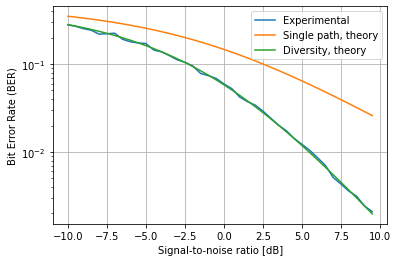

In [7]:
snr_range = np.arange(-10, 10, 0.5)
L = 2
# Simulate pulse position modulation
simulate(
    snr_range,      # SNR values
    500,            # Maximum error count
    lambda x: cdma_single_run(x, L)
)
# todo: add theoretical ber here from slides
plt.plot(snr_range, get_ber_coherent(snr_range))
plt.plot(snr_range, bpsk_diversity_ber(snr_range, L))
plt.ylabel('Bit Error Rate (BER)')
plt.legend(['Experimental', 'Single path, theory', 'Diversity, theory'])
plt.show()

## CDMA with pseudo-random sequences and interference power

* Consider multiple users and single-path synchronous Rayleigh fading model
* Let us construct power to interference ratio when the number of active users grows

In [8]:
def sir_single_run(n, K):
    # n: spreading factor
    # K: the number of active users
    # Synchronized single path AWGN communication assumed
    tx_spread = gen_spreading_sequence(n)
    
    # Interference:
    # Generate pseudo-random sequences
    interference = np.random.normal(size=(n, K - 1)) + 1j * np.random.normal(size=(n, K - 1))
    # Normalize these sequences
    interference = interference / np.expand_dims(np.linalg.norm(interference, axis=0), axis=0)
    # Perform summation at the receiver
    interference = np.sum(interference, axis=1)
    # Apply matched filter to transmitted sequence
    interference_filtered = np.convolve(interference, np.conj(np.flip(tx_spread)), 'valid')
    # Return interference power
    return np.abs(interference_filtered[0]) ** 2. # Convert single-element array to double by taking [0] index

sir_single_run(256, 100)

0.6135306165186869

In [9]:
# Run multiple experiments to average the signal-to-interference ratio
def evaluate_K(K):
    n = 128  # Spreading sequence length
    n_experiments = 1000  # Number of experiments for single point
    sir_linear = np.zeros(n_experiments,)
    for i in range(n_experiments):
        sir_linear[i] = sir_single_run(n, K)
    return 10 * np.log10(np.mean(sir_linear))

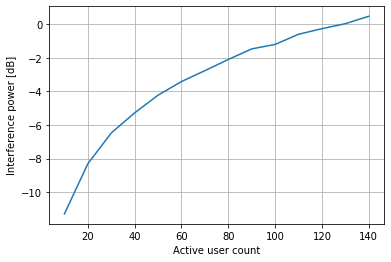

In [10]:
# Construct SIR plot
K = np.arange(10, 150, 10)
interference_power = np.zeros(len(K),)
for i, k in enumerate(K):
    interference_power[i] = evaluate_K(k)

plt.plot(K, interference_power)
plt.xlabel('Active user count')
plt.ylabel('Interference power [dB]')
plt.grid()

# Orthogonal frequency division multiplexing
## OFDM Spectrum

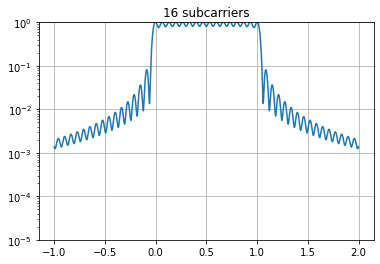

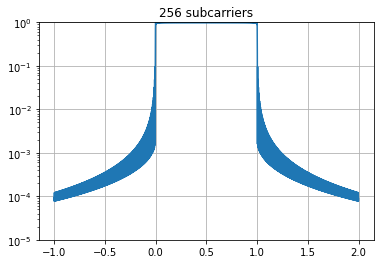

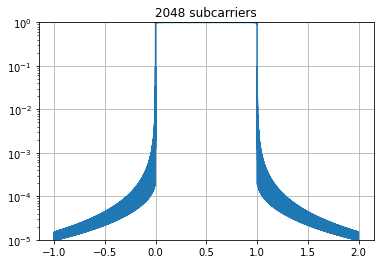

In [11]:
def plot_ofdm_spectrum(N, do_plot_subcarriers=False):
    # N: the number of subcarriers
    f = np.arange(-1, 2, 1e-4)  # Normalized frequency
    F = np.zeros_like(f)
    for i in range(N):
        carrier_psd = np.sinc((f - i / (N - 1)) * N) ** 2
        if do_plot_subcarriers:
            plt.plot(f, carrier_psd)
        F += carrier_psd
    plt.semilogy(f, F)
    plt.ylim([1e-5, 1])
    plt.grid()
    plt.show()

for N in [16, 256, 2048]:
    plt.figure()
    plt.title('{0} subcarriers'.format(N))
    plot_ofdm_spectrum(N)

## OFDM Peak-to-average power ratio (PAPR)

In [12]:
def papr_single_run(N):
    u = np.random.randn(N,) + 1j * np.random.randn(N,)
    t = np.abs(np.fft.ifft(u))
    return np.max(t**2) / np.mean(t**2)


for i in np.arange(5, 14):
    N = 2 ** i
    n_experiments = 1000
    papr_vals = np.zeros(n_experiments,)
    for j in range(n_experiments):
        papr_vals[j] = papr_single_run(N)
    papr = 10 * np.log10(np.mean(papr_vals))
    print(('N = %04d,\t PAPR = % 1.3f [dB]' % (N, papr)))

N = 0032,	 PAPR =  6.094 [dB]
N = 0064,	 PAPR =  6.762 [dB]
N = 0128,	 PAPR =  7.319 [dB]
N = 0256,	 PAPR =  7.861 [dB]
N = 0512,	 PAPR =  8.342 [dB]
N = 1024,	 PAPR =  8.767 [dB]
N = 2048,	 PAPR =  9.189 [dB]
N = 4096,	 PAPR =  9.486 [dB]
N = 8192,	 PAPR =  9.799 [dB]


## Check the cyclic convolution property

In [13]:
N = 1024

# Generate the channel impulse response and plot its spectrum
h_taps = 256
h = np.random.randn(h_taps,) + 1j * np.random.randn(h_taps,)
h_full = np.zeros(N,) + 1j * np.zeros(N,)
h_full[:h_taps] = h
Fh = np.fft.fft(h_full)
# plt.plot(np.fft.fftshift(np.abs(Fh)))
print(Fh.shape)

# Generate an OFDM symbol
n_cp = 257  # The cyclic prefix length (longer than the channel impulse response)
u = np.random.randn(N,) + 1j * np.random.randn(N,)  # Random numbers to transmit (frquency domain)
t = np.fft.ifft(u)  # Construct the time domain signal (time domain)

# Insert the cyclic prefix
t = np.hstack([t[-n_cp:], t])
print('Time domain signal shape:', t.shape)
# Convolve the time-domain signal with the channel impulse response
yt = np.convolve(t, h, 'full')
print('Full received sequence shape: ', yt.shape)
# Select the samples corresponding to the transmitted symbol only
yt = yt[n_cp:(n_cp + N)]
print('CP cut procedure, resulting shape:', yt.shape)
yf = np.fft.fft(yt)  # Switch to frequency domain
u_hat = yf / Fh
print('Restored signal error: %1.3f' % np.linalg.norm(u_hat - u))

(1024,)
Time domain signal shape: (1281,)
Full received sequence shape:  (1536,)
CP cut procedure, resulting shape: (1024,)
Restored signal error: 0.000
